# Querying Data

```{seealso}
The Vast DB SDK API Documentation is available [here](https://vastdb-sdk.readthedocs.io).
```

```{important}
This notebook is in the process of being migrated to Vast Data Platform Field Docs.  It will probably not run yet.
```

## Query and Filter

**Filtering** 
VAST-DB Supports filtering using a complete set of predicates. These predicates can be used directly with the VAST-DB APIs or used by analytics engines that can “push down” operations to VAST-DB. 


**Filtering Mechanics**

When searching for data, VAST-DB will use a distributed tree scan operation over range blocks in the element store, comparing the metadata in the bitmap blocks and eliminating blocks/sections of the tree based on min/max values. The search efficiency is directly related to the randomness of the column data referred to by the bitmap blocks. Best case scenario would be a search over a column whose values range linearly (greatest to least or least to greatest) relative to the keyspace without any overlap in the index blocks - reads of data blocks to find matching data are largely eliminated in this case. While the worst case would be a search on data that is random relative to the key space forcing reads on large sections of column data to perform comparisons. VAST-DB 5.0 will support sorted projections which will act similarly to indices to enable “best case” (ordered) scenarios on a given column or columns.


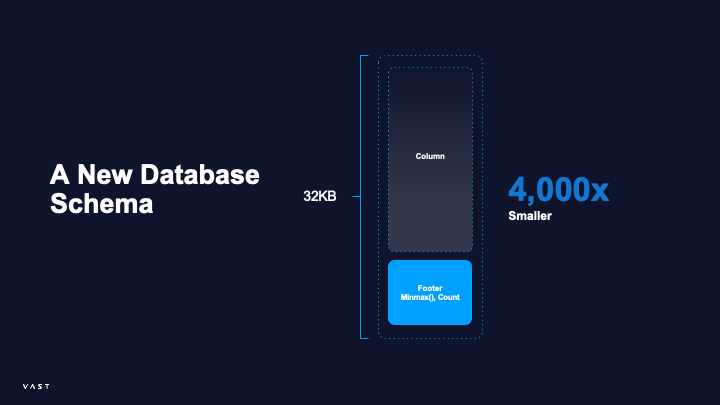


If we compare it with Parquet it allows us to store the data in much smaller elements and at a very fine granular level which is 4000x smaller compared to a standard parquet file with 128MB. 

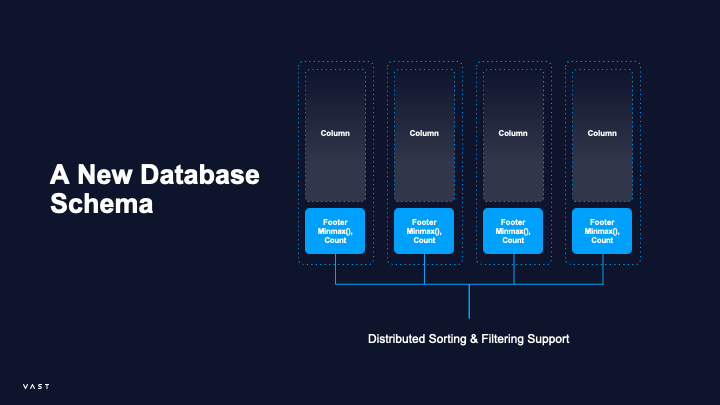

The Data is distributed and sorted. We are keeping min and max stats and the count for each column. This allows us to allow for filter push downs and we are able to skip and reduce the amount of data that we have to transfer back to the query engine. 

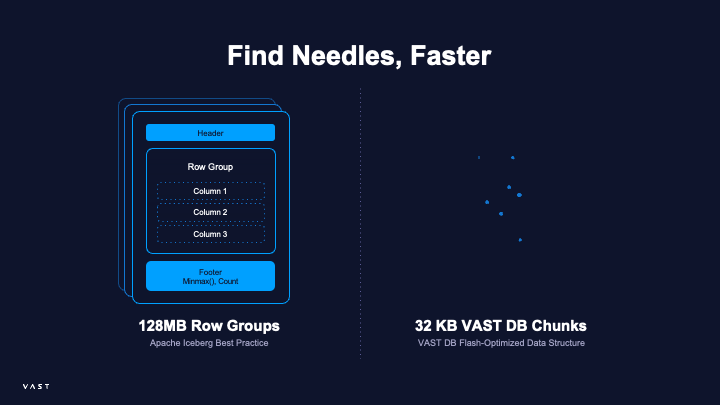

### `select`

- **Usage**: Execute a data query on a specified table within a bucket and schema. This function allows for complex queries, including filters and projections, on the table data.
- **Parameters**:
  - `columns` (list[str], optional): List of column names to be included in the query. If None, all columns are included.
  - `predicate` (dict, optional): A filter to apply to the query. See [filters-and-projections](https://github.com/vast-data/vastdb_sdk/blob/main/README.md#filters-and-projections) for more details.
  - `config` (QueryConfig, optional): Configuration options for the query execution. If None, default configuration is used. See the source for [vastdb.table.QueryConfig](https://github.com/vast-data/vastdb_sdk/blob/main/vastdb/table.py).
  - `internal_row_id` (bool, optional): If True, includes the internal row ID in the query.

- **Returns**:
  - `pa.RecordBatchReader`: A reader object that can be iterated to retrieve the query results as record batches.
 
- **Raises**:
  - `errors.TooLargeRequest`: If the serialized query data request size exceeds the maximum allowed size.
  - `StoppedException`: If the stop event is set during the execution of the query.

## Create a table with Citizen information


### Specify the Citizen Table


In [36]:
## Define the Table name for the citizen table

TABLE_NAME='pythonsdkcitizen'

### Define the Citizen Table


In [37]:
import pyarrow as pa
from vastdb.errors import TableExists

ARROW_SCHEMA = pa.schema([
        ('Citizen_Age', pa.int64()),
        ('Citizen_Name', pa.string()),
        ('Citizen_experience', pa.float64()),
        ('Is_married', pa.bool_()),
    ])


with session.transaction() as tx:
    try:
        schema = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA, fail_if_missing=False)
        if schema:
            try:
                table = schema.create_table(table_name=TABLE_NAME, columns=ARROW_SCHEMA)
                print(f"Table created: {table.name}")
            except TableExists as e:
                print("Couldn't create table because it already exists:", e)
            except Exception as e:
                print("Couldn't create table:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Table created: pythonsdkcitizen


### Insert rows into the Citizen Table


In [38]:
ROWS = { 
    'Citizen_Name': ['Alice', 'Bob', 'Koko', 'Menny'],
    'Citizen_Age': [45, 38, 27, 51],
    'Citizen_experience': [25.5, 17.9, 5.3, 28.2],
    'Is_married': [True, False, False, True]
}
PA_RECORD_BATCH = pa.RecordBatch.from_pydict(ROWS)


with session.transaction() as tx:
    try:
        schema = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA, fail_if_missing=False)
        if schema:
            try:
                table = schema.table(name=TABLE_NAME)
                table.insert(PA_RECORD_BATCH)
                print("Data inserted.")
            except Exception as e:
                print("Couldn't insert data:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Data inserted.


This uses the [RecordBatch.from_pydict](https://arrow.apache.org/docs/python/generated/pyarrow.RecordBatch.html#pyarrow.RecordBatch.from_pydict) method.  See also:

- [RecordBatch.from_arrays](https://arrow.apache.org/docs/python/generated/pyarrow.RecordBatch.html#pyarrow.RecordBatch.from_arrays)
- [RecordBatch.from_pandas](https://arrow.apache.org/docs/python/generated/pyarrow.RecordBatch.html#pyarrow.RecordBatch.from_pandas)
- [RecordBatch.from_pylist](https://arrow.apache.org/docs/python/generated/pyarrow.RecordBatch.html#pyarrow.RecordBatch.from_pylist)
- [RecordBatch.from_struct_array](https://arrow.apache.org/docs/python/generated/pyarrow.RecordBatch.html#pyarrow.RecordBatch.from_struct_array)

## Query the table and list all rows for the Citizen Table


In [39]:
with session.transaction() as tx:
    try:
        schema = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA, fail_if_missing=False)
        if schema:
            try:
                table = schema.table(name=TABLE_NAME)
                reader = table.select()
                pyarrow_table = pa.Table.from_batches(reader)
                df = pyarrow_table.to_pandas()
                display(df)
            except Exception as e:
                print("Couldn't select data:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Citizen_Age Citizen_Name  Citizen_experience  Is_married
0           45        Alice                25.5        True
1           38          Bob                17.9       False
2           27         Koko                 5.3       False
3           51        Menny                28.2        True

This uses the [Table.to_pandas](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pandas) method.  See also:

- [Table.to_batches](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_batches)
- [Table.to_pydict](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pydict)
- [Table.to_pylist](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pylist)
- [Table.to_reader](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_reader)
- [Table.to_string](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_string)
- [Table.to_struct_array](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_struct_array)

## (Filter) Predicates in VastdbApi
- You can use these predicates in the VastdbApi API:  

  - **`eq`**: Equal -> `'column_name': ['eq value']`
  - **`ge`**: Greater Than or Equal -> `'column_name': ['ge value']`
  - **`gt`**: Greater Than -> `'column_name': ['gt value']`
  - **`lt`**: Less Than -> `'column_name': ['lt value']`
  - **`le`**: Less Than or Equal -> `'column_name': ['le value']`
  - **`is_null`**: Checks for null values -> `'column_name': ['is_null']`
  - **`is_not_null`**: Checks for non-null values -> `'column_name': ['is_not_null']`
**Note:**
  - If using pandas dataframe, pandas predicates can also be used. (Perfomance might be reflected because it's not API-native filters)
    - **Example** [Query a table using Pandas predicates](#query-a-table-using-pandas-predicates)
  

## Filter Columns
We want to filter and project only the following columns:
- Citizen_Age
- Citizen_Name
- Citizen_experience

In [40]:
COLUMNS=['Citizen_Age', 'Citizen_Name', 'Citizen_experience']

with session.transaction() as tx:
    try:
        schema = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA, fail_if_missing=False)
        if schema:
            try:
                table = schema.table(name=TABLE_NAME)
                reader = table.select(columns=COLUMNS)
                pyarrow_table = pa.Table.from_batches(reader)
                df = pyarrow_table.to_pandas()
                display(df)
            except Exception as e:
                print("Couldn't select data:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Citizen_Age Citizen_Name  Citizen_experience
0           45        Alice                25.5
1           38          Bob                17.9
2           27         Koko                 5.3
3           51        Menny                28.2

## Filter data and columns

**(Citizen_Age > 37) AND (Citizen_experience <= 40) limit 10**


In [41]:
from ibis import _

PREDICATE = (_.Citizen_Age > 37) & (_.Citizen_experience <= 40)
COLUMNS = ['Citizen_Age', 'Citizen_Name', 'Citizen_experience']

with session.transaction() as tx:
    try:
        schema = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA, fail_if_missing=False)
        if schema:
            try:
                table = schema.table(name=TABLE_NAME)
                reader = table.select(columns=COLUMNS, predicate=PREDICATE)
                pyarrow_table = pa.Table.from_batches(reader)
                df = pyarrow_table.to_pandas()
                display(df)
            except Exception as e:
                print("Couldn't select data:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Citizen_Age Citizen_Name  Citizen_experience
0           45        Alice                25.5
1           38          Bob                17.9
2           51        Menny                28.2

**(Citizen_Age = 45) OR (Citizen_Age = 51)**


In [42]:
from ibis import _

PREDICATE = (_.Citizen_Age.isin([45,51]))
COLUMNS = ['Citizen_Age', 'Citizen_Name', 'Citizen_experience']

with session.transaction() as tx:
    try:
        schema = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA, fail_if_missing=False)
        if schema:
            try:
                table = schema.table(name=TABLE_NAME)
                reader = table.select(columns=COLUMNS, predicate=PREDICATE)
                pyarrow_table = pa.Table.from_batches(reader)
                df = pyarrow_table.to_pandas()
                display(df)
            except Exception as e:
                print("Couldn't select data:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Citizen_Age Citizen_Name  Citizen_experience
0           45        Alice                25.5
1           51        Menny                28.2

**(Citizen_experience <= 28) AND (Citizen_Age between 30 to 60)**


In [43]:
from ibis import _

PREDICATE = (_.Citizen_experience >= 28) & (_.Citizen_Age >= 30) & (_.Citizen_Age <= 60)
COLUMNS = ['Citizen_Age', 'Citizen_Name', 'Citizen_experience']

with session.transaction() as tx:
    try:
        schema = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA, fail_if_missing=False)
        if schema:
            try:
                table = schema.table(name=TABLE_NAME)
                reader = table.select(columns=COLUMNS, predicate=PREDICATE)
                pyarrow_table = pa.Table.from_batches(reader)
                df = pyarrow_table.to_pandas()
                display(df)
            except Exception as e:
                print("Couldn't select data:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Citizen_Age Citizen_Name  Citizen_experience
0           51        Menny                28.2

(query-a-table-using-pandas-predicates)=
## Query a table using Pandas predicates

This performs client side querying.


In [44]:
with session.transaction() as tx:
    try:
        schema = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA, fail_if_missing=False)
        if schema:
            try:
                table = schema.table(name=TABLE_NAME)
                reader = table.select()
                pyarrow_table = pa.Table.from_batches(reader)
                df = pyarrow_table.to_pandas()
                # pandas client side querying
                display(df[(df['Citizen_Age'] == 38) & (df['Citizen_experience'] > 2)].head(10))
            except Exception as e:
                print("Couldn't select data:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Citizen_Age Citizen_Name  Citizen_experience  Is_married
1           38          Bob                17.9       False